In [1]:
!pip install openai-clip
!pip install datasets
!pip install torch
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=2ea6d21108ccb8036caa6850de39de388fa918e8f464452787a6284b1914f270
  Stored in directory: /root/.cache/pip/wheels/08/77/8e/8d2f862df6bf7fb4e2007062d2cbaeae49862ec7b56d041229
Successfully built openai-clip


In [2]:
IMG_SIZE = (224, 224)
NUM_CLASSES = 4

In [3]:
VIDEO_PATH = "/kaggle/input/unber-1111/UNBER-1k/Extracted_Frames"

In [4]:
def load_video_frames(folder_path):
    frames = []
    frame_files = sorted(os.listdir(video_folder))
    for file in frame_files:
        img_path = os.path.join(video_folder, file)
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img)
        frames.append(img)

    return np.array(frames)

In [19]:
X_video, y = [], []

In [6]:
TEXT_CSV = "/kaggle/input/unber-1111/UNBER-1k/text.csv"

In [7]:
import pandas as pd
tdf = pd.read_csv(TEXT_CSV)

In [8]:
tdf['Visual texts'] = tdf['Visual texts'].fillna("কোন টেক্সট পাওয়া যায়নি")

In [9]:
tdf['UnsafeType'], uniques = pd.factorize(tdf['UnsafeType'])
uniques

Index(['Safe', 'Adult', 'Harmful', 'Suicidal'], dtype='object')

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [20]:
import os
import numpy as np

for _, row in tdf.iterrows():
    reel_id = row["reel_id"].split("/")[-1]  
    label = row["UnsafeType"]  

    video_folder = os.path.join(VIDEO_PATH, reel_id)

    if os.path.isdir(video_folder):
        frames = load_video_frames(video_folder)    

        X_video.append(frames)
        y.append(label)

In [21]:
print(len(X_video), len(y))

1111 1111


In [22]:
X_video = np.array(X_video)  
y = np.array(y)

In [23]:
print(X_video.shape)
print(y.shape)

(1111, 5, 224, 224, 3)
(1111,)


In [24]:
X_train_vid, X_temp, y_train, y_temp = train_test_split(X_video, y, test_size=0.2, random_state=42, stratify=y)
X_val_vid, X_test_vid, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [25]:
print(X_train_vid.shape)
print(X_val_vid.shape)
print(X_test_vid.shape)

(888, 5, 224, 224, 3)
(111, 5, 224, 224, 3)
(112, 5, 224, 224, 3)


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import clip
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [27]:
model_clip, preprocess = clip.load("ViT-B/32", jit=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_clip.to(device)

100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 46.2MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [28]:
def extract_clip_features(frames):
    frames = torch.stack([preprocess(Image.fromarray(np.uint8(frame))) for frame in frames])  # Transform all frames
    frames = frames.to(device)
    
    with torch.no_grad():
        features = model_clip.encode_image(frames).float()  # Extract features
    
    return features

In [29]:
class VideoDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        video_frames = self.X[idx]  # Shape: (n_frame, 224, 224, 3)
        label = self.y[idx]

        # Extract features for all frames
        frame_features = extract_clip_features(video_frames)  # Shape: (n_frame, feature_dim)
        
        return frame_features, label

In [30]:
batch_size = 8  # Adjust based on available memory
train_loader = DataLoader(VideoDataset(X_train_vid, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(VideoDataset(X_val_vid, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(VideoDataset(X_test_vid, y_test), batch_size=batch_size, shuffle=False)

In [31]:
class CLIP_LSTM(nn.Module):
    def __init__(self, feature_dim=512, hidden_dim=256, num_layers=2, num_classes=4):
        super(CLIP_LSTM, self).__init__()
        self.lstm = nn.LSTM(feature_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)  # Take the last hidden state
        output = self.fc(h_n[-1])  # Last layer's hidden state
        return output

In [32]:
model_ft = CLIP_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=1e-4)

In [33]:
num_epochs = 20

In [35]:
from PIL import Image

In [36]:
for epoch in range(num_epochs):
    model_ft.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")

    for frame_features, labels in pbar:
        frame_features, labels = frame_features.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model_ft(frame_features)  # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Validation Accuracy
    model_ft.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for frame_features, labels in val_loader:
            frame_features, labels = frame_features.to(device), labels.to(device)
            outputs = model_ft(frame_features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Validation Accuracy: {100 * correct / total:.2f}%')

Epoch 1/20, Loss: 1.2609: 100%|██████████| 111/111 [00:13<00:00,  8.01it/s]


Epoch [1/20], Loss: 1.2609
Validation Accuracy: 52.25%


Epoch 2/20, Loss: 0.9416: 100%|██████████| 111/111 [00:12<00:00,  8.62it/s]


Epoch [2/20], Loss: 0.9416
Validation Accuracy: 63.96%


Epoch 3/20, Loss: 0.8120: 100%|██████████| 111/111 [00:12<00:00,  8.66it/s]


Epoch [3/20], Loss: 0.8120
Validation Accuracy: 65.77%


Epoch 4/20, Loss: 0.7468: 100%|██████████| 111/111 [00:13<00:00,  8.49it/s]


Epoch [4/20], Loss: 0.7468
Validation Accuracy: 66.67%


Epoch 5/20, Loss: 0.6885: 100%|██████████| 111/111 [00:12<00:00,  8.62it/s]


Epoch [5/20], Loss: 0.6885
Validation Accuracy: 69.37%


Epoch 6/20, Loss: 0.6333: 100%|██████████| 111/111 [00:13<00:00,  8.51it/s]


Epoch [6/20], Loss: 0.6333
Validation Accuracy: 69.37%


Epoch 7/20, Loss: 0.5683: 100%|██████████| 111/111 [00:12<00:00,  8.63it/s]


Epoch [7/20], Loss: 0.5683
Validation Accuracy: 70.27%


Epoch 8/20, Loss: 0.5126: 100%|██████████| 111/111 [00:13<00:00,  8.51it/s]


Epoch [8/20], Loss: 0.5126
Validation Accuracy: 68.47%


Epoch 9/20, Loss: 0.4476: 100%|██████████| 111/111 [00:12<00:00,  8.65it/s]


Epoch [9/20], Loss: 0.4476
Validation Accuracy: 68.47%


Epoch 10/20, Loss: 0.4022: 100%|██████████| 111/111 [00:12<00:00,  8.61it/s]


Epoch [10/20], Loss: 0.4022
Validation Accuracy: 67.57%


Epoch 11/20, Loss: 0.3402: 100%|██████████| 111/111 [00:12<00:00,  8.65it/s]


Epoch [11/20], Loss: 0.3402
Validation Accuracy: 60.36%


Epoch 12/20, Loss: 0.2625: 100%|██████████| 111/111 [00:12<00:00,  8.61it/s]


Epoch [12/20], Loss: 0.2625
Validation Accuracy: 58.56%


Epoch 13/20, Loss: 0.2395: 100%|██████████| 111/111 [00:12<00:00,  8.60it/s]


Epoch [13/20], Loss: 0.2395
Validation Accuracy: 64.86%


Epoch 14/20, Loss: 0.1815: 100%|██████████| 111/111 [00:12<00:00,  8.66it/s]


Epoch [14/20], Loss: 0.1815
Validation Accuracy: 63.06%


Epoch 15/20, Loss: 0.1891: 100%|██████████| 111/111 [00:12<00:00,  8.57it/s]


Epoch [15/20], Loss: 0.1891
Validation Accuracy: 63.06%


Epoch 16/20, Loss: 0.1359: 100%|██████████| 111/111 [00:12<00:00,  8.67it/s]


Epoch [16/20], Loss: 0.1359
Validation Accuracy: 59.46%


Epoch 17/20, Loss: 0.1138: 100%|██████████| 111/111 [00:13<00:00,  8.43it/s]


Epoch [17/20], Loss: 0.1138
Validation Accuracy: 60.36%


Epoch 18/20, Loss: 0.0878: 100%|██████████| 111/111 [00:12<00:00,  8.66it/s]


Epoch [18/20], Loss: 0.0878
Validation Accuracy: 59.46%


Epoch 19/20, Loss: 0.0664: 100%|██████████| 111/111 [00:13<00:00,  8.44it/s]


Epoch [19/20], Loss: 0.0664
Validation Accuracy: 61.26%


Epoch 20/20, Loss: 0.0485: 100%|██████████| 111/111 [00:12<00:00,  8.57it/s]


Epoch [20/20], Loss: 0.0485
Validation Accuracy: 63.96%


In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
model_ft.eval()
all_preds, all_labels = [], []

In [39]:
with torch.no_grad():
    for frame_features, labels in test_loader:
        frame_features, labels = frame_features.to(device), labels.to(device)
        outputs = model_ft(frame_features)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

In [40]:
print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.5208    0.5556    0.5376        45
           1     0.5758    0.5758    0.5758        33
           2     0.2727    0.2727    0.2727        22
           3     1.0000    0.7500    0.8571        12

    accuracy                         0.5268       112
   macro avg     0.5923    0.5385    0.5608       112
weighted avg     0.5396    0.5268    0.5311       112



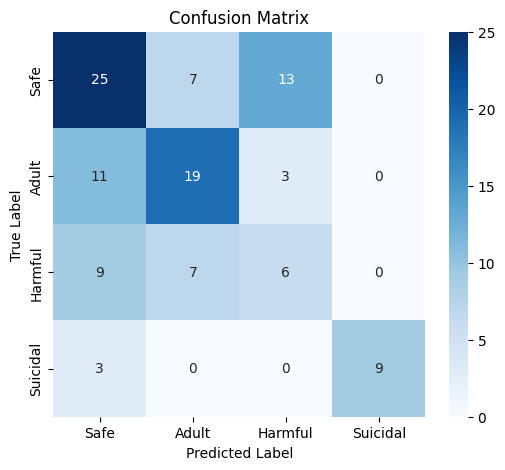

In [41]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Safe", "Adult", "Harmful", "Suicidal"], 
            yticklabels=["Safe", "Adult", "Harmful", "Suicidal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()